In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd
import random
import pickle
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, utils, preprocessing

In [2]:
path = "myData"  # folder with all the class folders
labelFile = 'labels.csv'  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 2000
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

In [3]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [5]:

print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[
    0]), "The number of images in not equal to the number of lables in training set"
assert (X_validation.shape[0] == y_validation.shape[
    0]), "The number of images in not equal to the number of lables in validation set"
assert (X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert (X_train.shape[1:] == (imageDimesions)), " The dimesions of the Training images are wrong "
assert (X_validation.shape[1:] == (imageDimesions)), " The dimesionas of the Validation images are wrong "
assert (X_test.shape[1:] == (imageDimesions)), " The dimesionas of the Test images are wrong"


Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [6]:
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


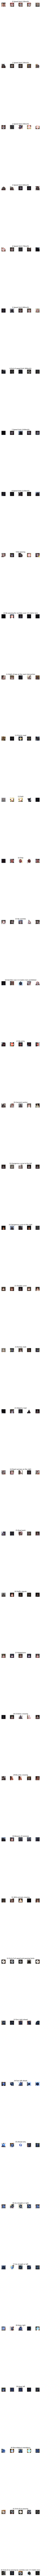

In [7]:

num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))

[105, 1304, 1293, 802, 1099, 1037, 226, 851, 822, 888, 1122, 743, 1235, 1199, 432, 372, 232, 642, 666, 108, 180, 161, 200, 291, 142, 833, 334, 142, 319, 151, 275, 462, 135, 381, 236, 687, 202, 115, 1225, 181, 183, 131, 127]


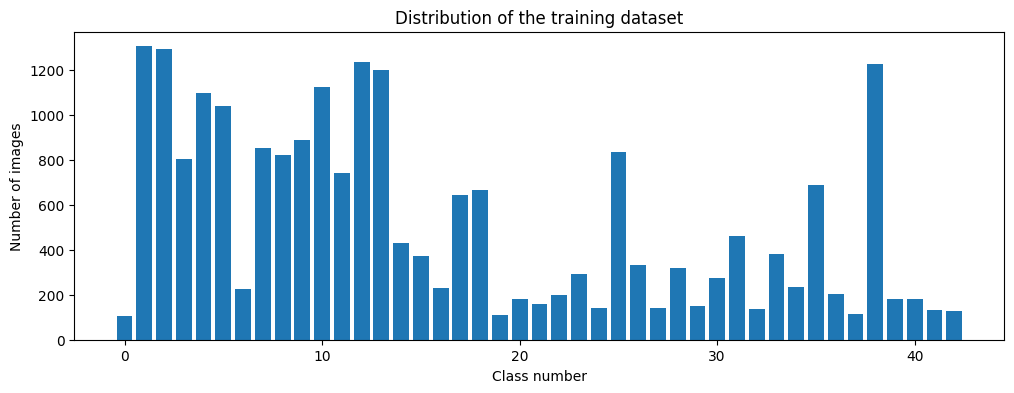

In [8]:
[]
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [9]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [10]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

In [11]:
def preprocess_image(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

In [12]:
X_train = np.array(list(map(preprocess_image, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocess_image, X_validation)))
X_test = np.array(list(map(preprocess_image, X_test)))
cv2.imshow("GrayScale Images",
           X_train[random.randint(0, len(X_train) - 1)])  # TO CHECK IF THE TRAINING IS DONE PROPERLY

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

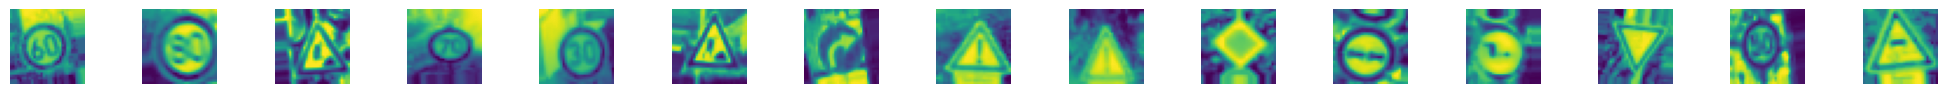

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataGen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,
                       batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

from tensorflow.keras.utils import to_categorical  # Importing from utils

# Convert labels to categorical
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)


In [15]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)  # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS
    model = layers.Sequential()
    model.add((layers.Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions[0], imageDimesions[1], 1),
                      activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((layers.Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(layers.MaxPooling2D(pool_size=size_of_pool))  # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((layers.Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((layers.Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(layers.MaxPooling2D(pool_size=size_of_pool))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(no_Of_Nodes, activation='relu'))
    model.add(layers.Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(layers.Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(layers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [16]:
from tensorflow.keras.models import Sequential  # Correct import for Sequential
from tensorflow.keras import layers, optimizers  # Import layers and optimizers properly

# Define your model architecture here
def myModel():
    size_of_Filter = (5, 5)
    size_of_Filter2 = (3, 3)
    no_Of_Filters = 60
    size_of_pool = (2, 2)
    no_Of_Nodes = 500  # Number of nodes in hidden layers
    
    model = Sequential()  # Use Sequential from models
    model.add(layers.Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions[0], imageDimesions[1], 1),
                            activation='relu'))
    model.add(layers.Conv2D(no_Of_Filters, size_of_Filter, activation='relu'))
    model.add(layers.MaxPool2D(pool_size=size_of_pool))
    model.add((layers.Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((layers.Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(layers.MaxPooling2D(pool_size=size_of_pool))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(no_Of_Nodes, activation='relu'))
    model.add(layers.Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(layers.Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    
    # COMPILE MODEL with updated learning_rate argument
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=steps_per_epoch_val, epochs=epochs_val,
                    validation_data=(X_validation, y_validation), shuffle=1)





C:\Users\manvi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


C:\Users\manvi\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 446/2000 ━━━━━━━━━━━━━━━━━━━━ 1:47 69ms/step - accuracy: 0.1364 - loss: 3.2285

c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.2404 - loss: 2.7780 - val_accuracy: 0.7556 - val_loss: 0.9895
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.6210 - loss: 1.2388 - val_accuracy: 0.9237 - val_loss: 0.3301
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.7480 - loss: 0.8081 - val_accuracy: 0.9643 - val_loss: 0.1862
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.8131 - loss: 0.6007 - val_accuracy: 0.9680 - val_loss: 0.1292
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.8470 - loss: 0.4912 - val_accuracy: 0.9666 - val_loss: 0.1095
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.8643 - loss: 0.4312 - val_accuracy: 0.9731 - val_loss: 0.0942
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.8783 - loss: 0.3845 - val_accuracy: 0.9837 - val_loss: 0.0628
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.8956 - loss: 0.33

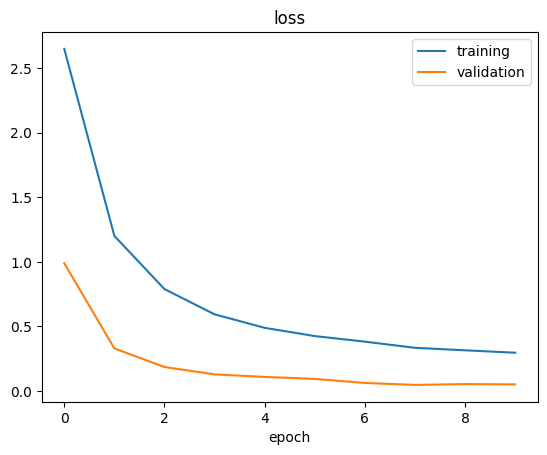

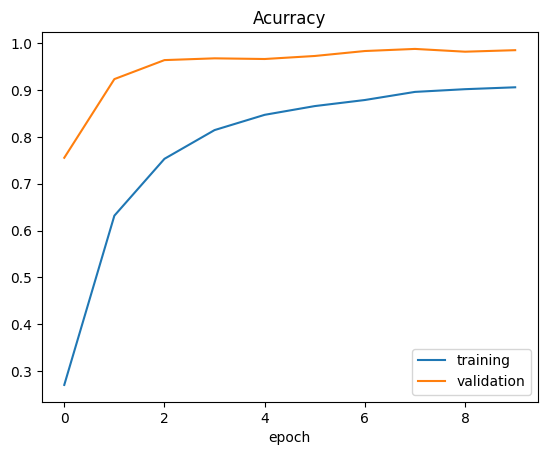

Test Score: 0.0487455390393734
Test Accuracy: 0.9840517044067383


In [17]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# STORE THE MODEL AS A PICKLE OBJECT
pickle_out = open("model_trained.p", "wb")  # wb = WRITE BYTE
pickle.dump(model, pickle_out)
pickle_out.close()